In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress as ip
import tldextract
import pickle as pkl
import sklearn.ensemble as ensembleLearning

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn import linear_model
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation

from urllib.parse import urlparse
from __future__ import division

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Original Dataset with Domain + Label with other features value
data = pd.read_csv('DataSet/PhishLegitimateDataSet.csv')
data.head()

,domain,ranking,mld_res,mld.ps_res,card_rem,ratio_Rrem,ratio_Arem,jaccard_RR,jaccard_RA,jaccard_AR,jaccard_AA,jaccard_ARrd,jaccard_ARrem,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,10000000,1.0,0.0,18,107.611111,107.277778,0.0,0.0,0.0,0.0,0.8,0.795729,1.0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,10000000,0.0,0.0,11,150.636364,152.272727,0.0,0.0,0.0,0.0,0.0,0.768577,1.0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,10000000,0.0,0.0,14,73.500000,72.642857,0.0,0.0,0.0,0.0,0.0,0.726582,1.0
3,mail.printakid.com/www.online.americanexpress....,10000000,0.0,0.0,6,562.000000,590.666667,0.0,0.0,0.0,0.0,0.0,0.859640,1.0
4,thewhiskeydregs.com/wp-content/themes/widescre...,10000000,0.0,0.0,8,29.000000,24.125000,0.0,0.0,0.0,0.0,0.0,0.748971,1.0


In [3]:
# Get domain and label only : 1st way
header = ['domain', 'label']
# Export to new CSV
data.to_csv('DataSet/PhishLegitimateDataSet_Cleaned1.csv', columns = header, index = False)

In [4]:
# Get domain and label only : 2nd way
dfRequired = data[['domain', 'label']]
# Export to new CSV
dfRequired.to_csv('DataSet/PhishLegitimateDataSet_Cleaned2.csv', index = False)
dfRequired.head()

,domain,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1.0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1.0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1.0
3,mail.printakid.com/www.online.americanexpress....,1.0
4,thewhiskeydregs.com/wp-content/themes/widescre...,1.0


In [5]:
# Helper Functions
def get_f1_score(Y_test, Y_predict, title):
    test_size = len(Y_test)
    score = 0
    
    for i in range(test_size):
        if Y_predict[i] == Y_test[i]:
            score += 1
            
    print('Got %s out of %s' % (score, test_size))
    print('f1 = %.2f' % (f1_score(Y_test, Y_predict, average = 'binary')))
    print('precision = %.2f' % (precision_score(Y_test, Y_predict, average = 'binary')))
    print('recall = %.2f' % (recall_score(Y_test, Y_predict, average = 'binary')))
    print('accuracy = %.2f' % (accuracy_score(Y_test, Y_predict)))

    bar_width = 0.20
    opacity = 0.4
    error_config = {'ecolor': '0.3'}
    index = np.arange(1)

    fig, ax = plt.subplots()

    ax.bar(index, f1_score(Y_test, Y_predict, average = 'binary'), bar_width,
           alpha = opacity, color = 'b',
           error_kw = error_config,
           label = 'F Score')
    ax.bar(index + bar_width * 1, precision_score(Y_test, Y_predict, average = 'binary'), bar_width,
           alpha = opacity, color = 'r',
           error_kw = error_config,
           label = 'Precision')
    ax.bar(index + bar_width * 2, recall_score(Y_test, Y_predict, average = 'binary'), bar_width,
           alpha = opacity, color = 'g',
           error_kw = error_config,
           label = 'Recall')
    ax.bar(index + bar_width * 3, accuracy_score(Y_test, Y_predict), bar_width,
           alpha = opacity, color = 'y',
           error_kw = error_config,
           label = 'Accuracy')
    ax.set_xlabel('Measures')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.tick_params(
        axis = 'x',           # changes apply to the x-axis
        which = 'both',       # both major and minor ticks are affected
        bottom = False,       # ticks along the bottom edge are off
        top = False,          # ticks along the top edge are off
        labelbottom = False)  # labels along the bottom edge are off
    ax.legend()
    fig.tight_layout()
    plt.show()

In [6]:
# Helper Functions
def get_domain_from_url(url):
    return url[:url.find('/',8)]

def get_path_from_url(url):
    return url[url.find('/',8):]

def get_length(str):
    return len(str)

def get_forward_slash_count(str):
    return str.count('/')

def get_dot_count(str):
    return str.count('.')

def get_delimeter_count(str):
    count = 0
    delim = [';', '_', '?', '=', '&']
    for each in str:
        if each in delim:
            count = count + 1
    return count

def isip(uri):
    try:
        if ip.ip_address(uri):
            return 1
    except:
        return 0
    
def get_hyphen_count(str):
    return str.count('-')

def get_at_count(str):
    return str.count('@')

def get_amp_count(str):
    return str.count('&')

# LEXICAL FEATURES
# URL Related
def get_forward_slash_count_in_url(url):
    return get_forward_slash_count(url)

def get_dot_count_in_url(url):
    return get_dot_count(url)

def get_url_length(url):
    return get_length(url)

# Domain Related
def get_forward_slash_count_in_domain(url):
    return get_forward_slash_count(get_domain_from_url(url))

def get_dot_count_in_domain(url):
    return get_dot_count(get_domain_from_url(url))

def get_domain_length(url):
    return get_length(get_domain_from_url(url))

# Path Related
def get_forward_slash_count_in_path(url):
    return get_forward_slash_count(get_path_from_url(url))

def get_dot_count_in_path(url):
    return get_dot_count(get_path_from_url(url))

def get_path_length(url):
    return get_length(get_path_from_url(url))

In [7]:
def make_feature_vector(from_index, url, label):
    feature_vector = []
    for i in range(len(url)):
        s = url[from_index + i]
        if len(s) > 0:
            s = str(s)
            path = urlparse(s)
            ext = tldextract.extract(s)
    
            feature = []

            #Syntatic
            feature.append(isip(ext.domain))
            feature.append(get_at_count(s))
            feature.append(get_hyphen_count(s))
            feature.append(get_amp_count(s))
            feature.append(get_delimeter_count(s))
        
            #URL Related
            feature.append(get_forward_slash_count_in_url(s))
            feature.append(get_dot_count_in_url(s))
            feature.append(get_url_length(s))

            #Sub-domain/Domain Related
            feature.append(get_forward_slash_count_in_domain(s))
            feature.append(get_dot_count_in_domain(s))
            feature.append(get_domain_length(s))

            #Path Related
            feature.append(get_forward_slash_count_in_path(s))
            feature.append(get_dot_count_in_path(s))
            feature.append(get_path_length(s))

            feature.append(len(path.netloc)) # domain name length
            feature.append(len(path.query))# number of queries
            
            #feature.append(label[from_index + i])
        feature_vector.append(feature)

    return feature_vector

In [8]:
def make_np_array_XY(xy):
    a = np.array(xy)
    x = a[:, 0:-1]
    y = a[:, -1]
    return x, y

In [9]:
from_index = 30000
to_index = 65000
cut_ratio = 0.9

In [10]:
url = dfRequired[['domain']].iloc[from_index:to_index, 0]
url.head()

30000    prades-consulting.com/www.paypal.fr/bd6e020e9c...
30001                                  arcot6.mcscsec.com/
30002    'aricilikmarketi.com/templates/estime_redberry...
30003    www.cocodelagalea.es/imagenes/www.vodafone.co....
30004    bankruptcyarmor.com/wp-includes/js/crop/www.vo...
Name: domain, dtype: object

In [11]:
label = dfRequired[['label']].iloc[from_index:to_index, 0]
label.head()

30000    1.0
30001    1.0
30002    1.0
30003    1.0
30004    1.0
Name: label, dtype: float64

In [12]:
print("Total Count : " + str(len(label)))

Total Count : 35000


In [13]:
def getFeatures(url, label): 
    s = str(url)
    path = urlparse(url)
    ext = tldextract.extract(url)

    feature = []

    #Syntatic
    feature.append(isip(ext.domain))
    feature.append(get_at_count(s))
    feature.append(get_hyphen_count(s))
    feature.append(get_amp_count(s))
    feature.append(get_delimeter_count(s))

    #URL Related
    feature.append(get_forward_slash_count_in_url(s))
    feature.append(get_dot_count_in_url(s))
    feature.append(get_url_length(s))

    #Sub-domain/Domain Related
    feature.append(get_forward_slash_count_in_domain(s))
    feature.append(get_dot_count_in_domain(s))
    feature.append(get_domain_length(s))

    #Path Related
    feature.append(get_forward_slash_count_in_path(s))
    feature.append(get_dot_count_in_path(s))
    feature.append(get_path_length(s))

    feature.append(len(path.netloc)) # domain name length
    feature.append(len(path.query))# number of queries

    feature.append(label)
    return feature

In [14]:
featureSet = pd.DataFrame(columns = (' is ip ',' @ count ',' - count ',' & count ',' delimeter count ',\
                                     ' url / count ',' url . count ',' url length ',\
                                     ' domain/subdomain / count ',' domain/subdomain . count ',' domain/subdomain length ',\
                                     ' path / count ',' path . count ',' path length ',\
                                     'domain name length','query count',\
                                     'label'))
featureSet.head()    

,is ip,@ count,- count,& count,delimeter count,url / count,url . count,url length,domain/subdomain / count,domain/subdomain . count,domain/subdomain length,path / count,path . count,path length,domain name length,query count,label


In [15]:
dfRequired_trim = dfRequired[from_index:to_index]
dfRequired_trim.head()

,domain,label
30000,prades-consulting.com/www.paypal.fr/bd6e020e9c...,1.0
30001,arcot6.mcscsec.com/,1.0
30002,'aricilikmarketi.com/templates/estime_redberry...,1.0
30003,www.cocodelagalea.es/imagenes/www.vodafone.co....,1.0
30004,bankruptcyarmor.com/wp-includes/js/crop/www.vo...,1.0


In [16]:
len(dfRequired_trim)

35000

In [17]:
print(dfRequired_trim["domain"].loc[0+from_index])

prades-consulting.com/www.paypal.fr/bd6e020e9ce0350d5ef1820fb309193f/


In [18]:
for i in range(len(dfRequired_trim)):
    features = getFeatures(dfRequired_trim["domain"].loc[i+from_index], dfRequired_trim["label"].loc[i+from_index])  
    featureSet.loc[i] = features

featureSet.head()  

,is ip,@ count,- count,& count,delimeter count,url / count,url . count,url length,domain/subdomain / count,domain/subdomain . count,domain/subdomain length,path / count,path . count,path length,domain name length,query count,label
0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,69.0,0.0,1.0,21.0,3.0,2.0,48.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,2.0,19.0,0.0,2.0,18.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,5.0,2.0,86.0,0.0,1.0,20.0,5.0,1.0,66.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,3.0,6.0,57.0,0.0,2.0,20.0,3.0,4.0,37.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,5.0,5.0,67.0,0.0,1.0,19.0,5.0,4.0,48.0,0.0,0.0,1.0


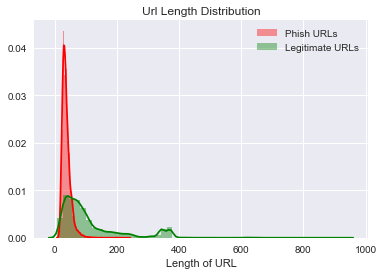

In [19]:
sns.set(style = "darkgrid")
sns.distplot(featureSet[featureSet['label'] == 0.0][' url length '], color='red', label = 'Phish URLs')
sns.distplot(featureSet[featureSet['label'] == 1.0][' url length '], color='green', label = 'Legitimate URLs')
plt.title('Url Length Distribution')
plt.legend(loc = 'upper right')
plt.xlabel('Length of URL')

plt.show()

In [27]:
featureSet.groupby(featureSet['label']).size()

label
0.0    17098
1.0    17902
dtype: int64

In [28]:
import sklearn
featureSet = sklearn.utils.shuffle(featureSet)

In [29]:
X = featureSet.drop(['label'], axis = 1).values
y = featureSet['label'].values

In [30]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,24.0,0.0,4.0,23.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,3.0,37.0,0.0,2.0,29.0,1.0,1.0,8.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,3.0,2.0,38.0,0.0,2.0,11.0,3.0,0.0,27.0,0.0,0.0
3,0.0,0.0,1.0,1.0,6.0,5.0,6.0,79.0,0.0,6.0,36.0,5.0,0.0,43.0,0.0,23.0
4,0.0,0.0,0.0,0.0,0.0,6.0,2.0,45.0,0.0,2.0,13.0,6.0,0.0,32.0,0.0,0.0


In [31]:
pd.DataFrame(y).head()

,0
0,1.0
1,0.0
2,0.0
3,1.0
4,0.0


In [32]:
model = {"DecisionTree":tree.DecisionTreeClassifier(max_depth=10),
         "RandomForest":ensembleLearning.RandomForestClassifier(n_estimators=50),
         "Adaboost":ensembleLearning.AdaBoostClassifier(n_estimators=50),
         "GradientBoosting":ensembleLearning.GradientBoostingClassifier(n_estimators=50),
         "GNB":GaussianNB(),
         "LogisticRegression":LogisticRegression()
}

In [33]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y ,test_size=0.2)

In [34]:
results = {}
for algo in model:
    clf = model[algo]
    clf.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print ("%s : %s " %(algo, score))
    results[algo] = score

DecisionTree : 0.888 
RandomForest : 0.901285714286 
Adaboost : 0.876142857143 
GradientBoosting : 0.877857142857 
GNB : 0.768428571429 
LogisticRegression : 0.821714285714 


In [35]:
winner = max(results, key=results.get)
print(winner)

RandomForest


In [36]:
clf = model[winner]
res = clf.predict(X)
mt = confusion_matrix(y, res)
print("False positive rate : %f %%" % ((mt[0][1] / float(sum(mt[0])))*100))
print('False negative rate : %f %%' % ( (mt[1][0] / float(sum(mt[1]))*100)))

False positive rate : 2.655281 %
False negative rate : 6.284214 %


In [37]:
len(url)

35000

In [ ]:
#features_and_labels = make_feature_vector(from_index, url, label)

#df_features_and_labels = pd.DataFrame(features_and_labels)
#df_features_and_labels.head()

In [ ]:
#len(features_and_labels)

In [ ]:
#features_and_labels = np.array(features_and_labels)
#random.shuffle(features_and_labels)

#cut = int(len(features_and_labels) * cut_ratio)
#XY_train = features_and_labels[:cut]
#XY_test = features_and_labels[cut:]

In [ ]:
#df_features_and_labels = pd.DataFrame(features_and_labels)
#df_features_and_labels.head()

In [ ]:
#X_train, Y_train = make_np_array_XY(XY_train)
#X_test, Y_test = make_np_array_XY(XY_test)

In [ ]:
#pd.DataFrame(X_train).head()

In [ ]:
#pd.DataFrame(Y_train).head()

In [ ]:
#len(X_train)

In [ ]:
#len(Y_train)

In [38]:
#SVM SVC Classifier with Linear Kernel
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel = 'linear', C = C).fit(X_train, y_train)

In [39]:
# Predicted Label
Y_predict = svc.predict(X_test)
(pd.DataFrame(Y_predict)).head()

,0
0,0.0
1,1.0
2,1.0
3,0.0
4,0.0


In [40]:
# Actual Label
(pd.DataFrame(y_test)).head()

,0
0,1.0
1,1.0
2,1.0
3,0.0
4,0.0


Got 5756 out of 7000
f1 = 0.81
precision = 0.89
recall = 0.75
accuracy = 0.82


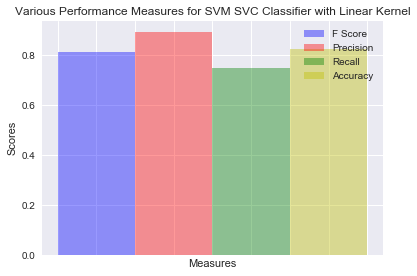

In [42]:
#test_size = len(Y_test)
#print('Got %s out of %s' % (score, test_size))
#print('f1 = %.2f' % (f1_score(Y_test, Y_predict, average = 'weighted')))
#print('precision = %.2f' % (precision_score(Y_test, Y_predict, average = 'weighted')))
#print('recall = %.2f' % (recall_score(Y_test, Y_predict, average = 'weighted')))
#print('accuracy = %.2f' % (accuracy_score(Y_test, Y_predict)))

#f1_score(Y_test, Y_predict, average = 'weighted')
get_f1_score(y_test, Y_predict, "Various Performance Measures for SVM SVC Classifier with Linear Kernel")